In [ ]:
# %% [markdown]
"""
# Gradient Boosting for Supply Chain Demand Forecasting (Hands-on, Job-Interview Ready)

This notebook is structured to teach gradient boosting **in code comments**. 
You'll:
1) Generate a realistic synthetic **daily demand** dataset for multiple SKUs and DCs.
2) Start with a simple baseline (Linear Regression).
3) Train a **GradientBoostingRegressor** with a robust pipeline.
4) Understand **how gradient boosting works** (stage-wise additive trees, gradients, shrinkage, subsampling).
5) Tune key hyperparameters + evaluate on a **time-based split**.
6) Inspect model: **feature importances, permutation importance, partial dependence**.
7) Plot **learning curves** via staged predictions to spot over/underfitting.
8) Do **what-if** (promo & price) scenario planning for planners.
9) BONUS: **HistGradientBoostingRegressor** (faster, binned histograms, early stopping).
10) End with an **interview Q&A cheat sheet** as comments.

"""


In [ ]:
# %% [markdown]
"""
## 0. Setup
- If a library is missing in your environment, uncomment the `pip` cell below and run it.
- We use only mainstream libs: numpy, pandas, scikit-learn, matplotlib.
"""


In [1]:
# %% 
# !pip install numpy pandas scikit-learn matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)  # Reproducibility


In [ ]:
# %% [markdown]
"""
## 1. Create a synthetic **supply chain** dataset
**Business story**: We forecast next-day demand for multiple SKUs shipped from multiple DCs.

**Signals we simulate**:
- Seasonality (week-of-year), day-of-week effects
- Price & promo (with uplift and price elasticity)
- Competitor price index
- Rolling lags (to mimic autocorrelation)
- Weak trend and noise

"""


In [3]:
# %%
def make_supply_chain_data(
    start="2023-01-01", 
    end="2024-12-31",
    n_skus=12,
    n_dcs=3,
    promo_rate=0.15
):
    """
    Generate a realistic daily panel:
    - rows: date × (sku, dc)
    - Features:
        * price: random near category baseline with SKU-specific elasticity
        * promo: Bernoulli with rate~promo_rate
        * comp_price_index: competitor price pressure index
        * dow, weekofyear, month: calendar signals
        * lags/rolling means: lag_7, lag_14, roll7
    - Target: 'demand'
    
    Demand formula (transparent):
        base = sku_base + dc_bias + seasonality + dow_effect + trend
        price_effect = - elasticity_sku * (price - sku_price_anchor)
        promo_effect = promo * sku_promo_uplift
        comp_effect = -0.4 * (comp_price_index - 1.0)  # higher competitor index suppresses our demand a bit
        noise ~ N(0, sigma)
        demand = max(0, base + price_effect + promo_effect + comp_effect + noise)
    """
    dates = pd.date_range(start, end, freq="D")
    skus = [f"SKU_{i:02d}" for i in range(1, n_skus+1)]
    dcs = [f"DC_{c}" for c in range(1, n_dcs+1)]
    
    # SKU-level anchors and elasticities
    rng = np.random.default_rng(42)
    sku_price_anchor = {sku: rng.uniform(8, 35) for sku in skus}
    sku_elasticity   = {sku: rng.uniform(0.2, 1.2) for sku in skus}  # higher => more sensitive to price
    sku_promo_uplift = {sku: rng.uniform(3, 15) for sku in skus}
    sku_base_demand  = {sku: rng.uniform(20, 120) for sku in skus}
    dc_bias          = {dc: rng.uniform(-10, 10) for dc in dcs}
    
    rows = []
    for dt in dates:
        dow = dt.weekday()  # 0=Mon,...,6=Sun
        weekofyear = dt.isocalendar().week
        month = dt.month
        # smooth yearly seasonality: peaks mid-year, lower in winter (example)
        season = 10 * np.sin(2*np.pi*(dt.timetuple().tm_yday)/365)  
        # mild trend: +0.01 units per day
        trend = 0.01 * (dt - dates[0]).days
        
        for sku in skus:
            for dc in dcs:
                # promo random (could be further constrained e.g., not back-to-back)
                promo = 1 if rng.random() < promo_rate else 0
                # competitor index ~ around 1.0
                comp_index = rng.normal(loc=1.0, scale=0.05)
                # price centered near anchor ± 15%
                price = sku_price_anchor[sku] * rng.uniform(0.85, 1.15)
                
                # day-of-week effect: weekends slightly higher (example: +5 Sun, +3 Sat)
                dow_effect = {5: 3.0, 6: 5.0}.get(dow, 0.0)
                
                base = sku_base_demand[sku] + dc_bias[dc] + season + dow_effect + trend
                price_effect = - sku_elasticity[sku] * (price - sku_price_anchor[sku])
                promo_effect = promo * sku_promo_uplift[sku]
                comp_effect  = -0.4 * (comp_index - 1.0)
                noise = rng.normal(0, 5)
                
                demand = max(0, base + price_effect + promo_effect + comp_effect + noise)
                
                rows.append({
                    "date": dt, "sku": sku, "dc": dc,
                    "price": round(float(price), 2),
                    "promo": promo,
                    "comp_price_index": round(float(comp_index), 3),
                    "dow": dow, "weekofyear": int(weekofyear), "month": month,
                    "demand": float(demand)
                })
    
    df = pd.DataFrame(rows).sort_values(["sku","dc","date"]).reset_index(drop=True)
    
    # Create lags/rolling by group without leakage (shift first, then rolling)
    def add_lags(group):
        group = group.sort_values("date").copy()
        group["lag_7"]  = group["demand"].shift(7)
        group["lag_14"] = group["demand"].shift(14)
        group["roll7"]  = group["demand"].shift(1).rolling(7).mean()
        return group
    
    df = df.groupby(["sku","dc"], group_keys=False).apply(add_lags)
    
    # Drop first 14 days per SKU/DC where lags are NaN
    df = df.dropna().reset_index(drop=True)
    return df

df = make_supply_chain_data()
print(df.shape)
df.head(3)


(25812, 13)


,date,sku,dc,price,promo,comp_price_index,dow,weekofyear,month,demand,lag_7,lag_14,roll7
0,2023-01-15,SKU_01,DC_1,27.69,0,0.962,6,2,1,40.393855,46.270882,45.657268,39.936527
1,2023-01-16,SKU_01,DC_1,27.34,0,0.994,0,3,1,50.884322,35.020497,41.622630,39.096952
2,2023-01-17,SKU_01,DC_1,26.62,0,0.955,1,3,1,42.928758,44.823249,29.938006,41.363212


In [ ]:
# %% [markdown]
"""
## 2. Train/Validation Split (time-based)
We simulate a **realistic** split: train on the earlier period, test on the later period.
This avoids look-ahead bias in time series flavored problems.
"""


In [5]:
# %%
# Time-based split: last ~3 months as test
cutoff_date = df["date"].max() - pd.Timedelta(days=90)
train_df = df[df["date"] <= cutoff_date].copy()
test_df  = df[df["date"]  > cutoff_date].copy()

features = ["sku","dc","price","promo","comp_price_index","dow","weekofyear","month","lag_7","lag_14","roll7"]
target   = "demand"

X_train, y_train = train_df[features], train_df[target]
X_test,  y_test  = test_df[features],  test_df[target]

cat_cols = ["sku","dc"]
num_cols = [c for c in features if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print(train_df["date"].min(), train_df["date"].max(), "-> train window")
print(test_df["date"].min(), test_df["date"].max(), "-> test window")


2023-01-15 00:00:00 2024-10-02 00:00:00 -> train window
2024-10-03 00:00:00 2024-12-31 00:00:00 -> test window


In [ ]:
# %% [markdown]
"""
## 3. Baseline: Linear Regression
Baseline sets expectations. If boosting can't beat it, something is off.
"""


In [7]:
# %%
lin_reg = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

lin_reg.fit(X_train, y_train)
pred_lr = lin_reg.predict(X_test)

def mape(y_true, y_pred, eps=1e-6):
    """
    Mean Absolute Percentage Error with protection against zero target.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > eps
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

metrics_lr = {
    "MAE": mean_absolute_error(y_test, pred_lr),
    "RMSE": mean_squared_error(y_test, pred_lr, squared=False),
    "MAPE%": mape(y_test, pred_lr)
}
metrics_lr


{'MAE': 4.754736330286139,
 'RMSE': 5.94453330236594,
 'MAPE%': 7.830158732540972}

In [ ]:
# %% [markdown]
r"""
## 4. Gradient Boosting: **How it works** (conceptual in code comments)

**Boosting = Additive modeling of weak learners (small trees) to reduce bias:**
- Initialize with a constant prediction (e.g., mean of y).
- For t in 1..T:
  1) Compute **residuals** (for squared loss) or **negative gradients** (for general losses).
  2) Fit a small decision tree to those residuals/gradients (this is the "weak learner").
  3) Update the model: F_t(x) = F_{t-1}(x) + learning_rate * tree_t(x)
- **Learning rate (shrinkage)** scales each step to avoid overfitting. Lower LR -> need more trees, but often better generalization.
- **Max depth / leaf size** controls tree complexity (too big -> overfit).
- **Subsample < 1.0** introduces randomness (Stochastic Gradient Boosting) -> reduces variance.
- **n_estimators** is the number of boosting stages (trees). More trees with low LR is common.

We’ll train:
- `GradientBoostingRegressor` (classic, exact splits).
- Key params we’ll demo:
  * n_estimators (stages)
  * learning_rate (shrinkage)
  * max_depth (tree depth via `max_depth` inside base learners = `max_depth` in scikit's GBDT)
  * subsample (for stochastic GB)
  * min_samples_leaf (regularization)
"""


In [9]:
# %%
gbr = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(
        loss="squared_error",   # default squared loss; could use 'absolute_error' or 'huber' for robustness
        n_estimators=300,       # number of trees (stages)
        learning_rate=0.05,     # shrinkage; lower -> more trees
        max_depth=3,            # depth of individual regression trees (controls complexity)
        subsample=0.8,          # stochastic GB: fit each stage on a random subsample -> reduces variance
        min_samples_leaf=20,    # prevents tiny leaves -> better generalization
        random_state=42
    ))
])

gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)

metrics_gbr = {
    "MAE": mean_absolute_error(y_test, pred_gbr),
    "RMSE": mean_squared_error(y_test, pred_gbr, squared=False),
    "MAPE%": mape(y_test, pred_gbr)
}
metrics_lr, metrics_gbr


({'MAE': 4.754736330286139,
  'RMSE': 5.94453330236594,
  'MAPE%': 7.830158732540972},
 {'MAE': 4.410677895601626,
  'RMSE': 5.487090620062895,
  'MAPE%': 7.392904418430758})

In [ ]:
# %% [markdown]
"""
## 5. Hyperparameter Tuning (TimeSeriesSplit)
Small grid to keep runtime friendly. Use **TimeSeriesSplit** to respect temporal order.
"""


In [11]:
# %%
tscv = TimeSeriesSplit(n_splits=4)

param_grid = {
    "model__n_estimators": [200, 300],
    "model__learning_rate": [0.03, 0.05],
    "model__max_depth": [2, 3],
    "model__subsample": [0.7, 0.9],
    "model__min_samples_leaf": [10, 20]
}

grid = GridSearchCV(
    estimator=Pipeline([("prep", preprocess),
                        ("model", GradientBoostingRegressor(random_state=42))]),
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
grid.best_params_, -grid.best_score_


({'model__learning_rate': 0.03,
  'model__max_depth': 3,
  'model__min_samples_leaf': 10,
  'model__n_estimators': 200,
  'model__subsample': 0.7},
 7.439480169282225)

In [18]:
# %%
best_gbr = grid.best_estimator_
pred_best = best_gbr.predict(X_test)
metrics_best = {
    "MAE": mean_absolute_error(y_test, pred_best),
    "RMSE": mean_squared_error(y_test, pred_best, squared=False),
    "MAPE%": mape(y_test, pred_best)
}
metrics_gbr, metrics_best


({'MAE': 4.410677895601626,
  'RMSE': 5.487090620062895,
  'MAPE%': 7.392904418430758},
 {'MAE': 4.547513144694511,
  'RMSE': 5.679111678114337,
  'MAPE%': 7.677220317705021})

In [ ]:
# %% [markdown]
"""
## 7. Partial Dependence Plots (PDP)
PDP shows the **marginal effect** of a feature on prediction, averaging other features.

We’ll inspect:
- price (elasticity)
- promo (uplift)
- weekofyear (seasonality)
"""


<Figure size 400x300 with 0 Axes>

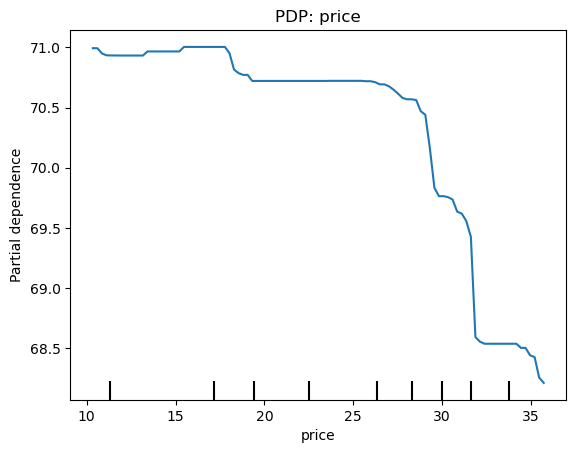

<Figure size 400x300 with 0 Axes>

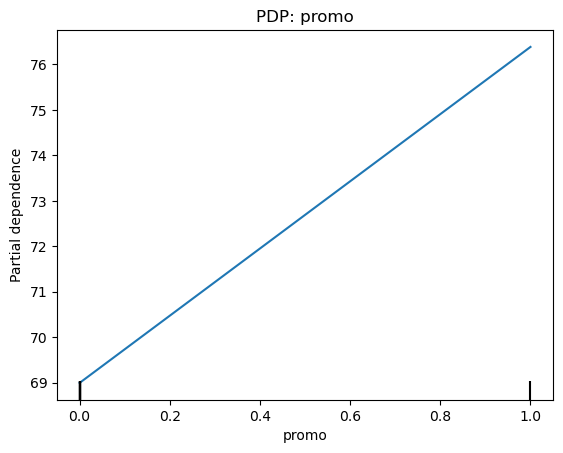

<Figure size 400x300 with 0 Axes>

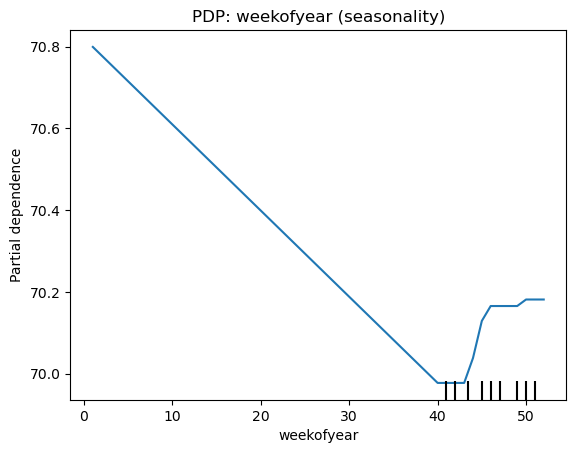

In [22]:
# %%
fig1 = plt.figure(figsize=(4,3))
PartialDependenceDisplay.from_estimator(best_gbr, X_test, ["price"])
plt.title("PDP: price")
plt.show()

fig2 = plt.figure(figsize=(4,3))
PartialDependenceDisplay.from_estimator(best_gbr, X_test, ["promo"])
plt.title("PDP: promo")
plt.show()

fig3 = plt.figure(figsize=(4,3))
PartialDependenceDisplay.from_estimator(best_gbr, X_test, ["weekofyear"])
plt.title("PDP: weekofyear (seasonality)")
plt.show()


In [ ]:
# %% [markdown]
"""
## 8. Learning Curves via Staged Predictions
We use `staged_predict` to compute test RMSE at each boosting stage to see:
- Underfitting (too few trees)
- Sweet spot (best generalization)
- Overfitting (too many trees)
"""


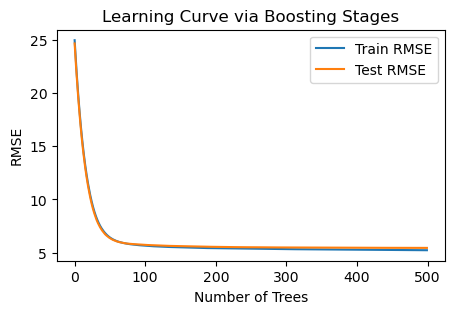

(5.449009392807679, 499)

In [24]:
# %%
# Refit a GBDT without pipeline just to access staged_predict easily on transformed data
X_train_t = preprocess.fit_transform(X_train)
X_test_t  = preprocess.transform(X_test)

plain_gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=20,
    random_state=42
)
plain_gbr.fit(X_train_t, y_train)

train_rmse, test_rmse = [], []
for y_tr_pred in plain_gbr.staged_predict(X_train_t):
    train_rmse.append(mean_squared_error(y_train, y_tr_pred, squared=False))

for y_te_pred in plain_gbr.staged_predict(X_test_t):
    test_rmse.append(mean_squared_error(y_test, y_te_pred, squared=False))

plt.figure(figsize=(5,3))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(test_rmse, label="Test RMSE")
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Learning Curve via Boosting Stages")
plt.legend()
plt.show()

best_stage = int(np.argmin(test_rmse))
float(np.min(test_rmse)), best_stage


In [ ]:
# %% [markdown]
"""
## 9. Scenario Planning: what-if (promo & price)
Planners ask: *"If we promote SKU_03 next week at DC_1 and drop price by 10%, what's the demand uplift?"*

We pick rows for a specific SKU/DC in the **first test week**, and compare predictions with two scenarios.
"""


In [26]:
# %%
# pick a scenario window
focus_sku = "SKU_03"
focus_dc  = "DC_1"
week_start = test_df["date"].min()
week_end   = week_start + pd.Timedelta(days=6)

scenario_rows = test_df[
    (test_df["sku"]==focus_sku) &
    (test_df["dc"]==focus_dc) &
    (test_df["date"].between(week_start, week_end))
].copy()

base_pred = best_gbr.predict(scenario_rows[features])

# Scenario A: add promo
scnA = scenario_rows.copy()
scnA["promo"] = 1
pred_A = best_gbr.predict(scnA[features])

# Scenario B: promo + 10% price drop
scnB = scnA.copy()
scnB["price"] = scnB["price"] * 0.90
pred_B = best_gbr.predict(scnB[features])

scn_out = pd.DataFrame({
    "date": scenario_rows["date"].values,
    "sku": focus_sku,
    "dc": focus_dc,
    "base_pred": base_pred,
    "promo_only": pred_A,
    "promo_price_drop": pred_B,
    "uplift_A": pred_A - base_pred,
    "uplift_B": pred_B - base_pred
})

print(f"Scenario window: {week_start.date()} to {week_end.date()} for {focus_sku} @ {focus_dc}")
scn_out.round(2)


Scenario window: 2024-10-03 to 2024-10-09 for SKU_03 @ DC_1


,date,sku,dc,base_pred,promo_only,promo_price_drop,uplift_A,uplift_B
0,2024-10-03,SKU_03,DC_1,45.08,52.01,53.52,6.93,8.44
1,2024-10-04,SKU_03,DC_1,43.33,50.45,50.91,7.11,7.58
2,2024-10-05,SKU_03,DC_1,45.10,53.01,53.01,7.91,7.91
3,2024-10-06,SKU_03,DC_1,52.87,52.87,53.86,0.00,0.99
4,2024-10-07,SKU_03,DC_1,41.28,48.81,50.94,7.53,9.66
5,2024-10-08,SKU_03,DC_1,44.32,52.37,52.37,8.05,8.05
6,2024-10-09,SKU_03,DC_1,41.75,49.50,50.53,7.74,8.78


In [ ]:
# %% [markdown]
"""
## 10. BONUS: HistGradientBoosting (fast, modern)
Key differences vs classic GBDT:
- **Histogram-based** binning -> very fast on large datasets.
- **Monotonic constraints** support, early stopping, missing value handling.
- Fewer knobs (no OneHot needed for pure numerical features; we still need encoding for categorical).
"""


In [28]:
# %%
# For a quick demo we reuse the OHE pipeline (categoricals stay encoded).
hgb = Pipeline([
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=6,            # depth is max # of splits from root (None means unlimited)
        max_iter=300,           # analogous to n_estimators
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ))
])

hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_test)

metrics_hgb = {
    "MAE": mean_absolute_error(y_test, pred_hgb),
    "RMSE": mean_squared_error(y_test, pred_hgb, squared=False),
    "MAPE%": mape(y_test, pred_hgb)
}
metrics_best, metrics_hgb


({'MAE': 4.547513144694511,
  'RMSE': 5.679111678114337,
  'MAPE%': 7.677220317705021},
 {'MAE': 4.415360223197394,
  'RMSE': 5.499103605857278,
  'MAPE%': 7.392613238186644})

In [ ]:
# %% [markdown]
r"""
## 11. Practical Guidance & Interview Notes (keep as comments in your repo)

### When to use Gradient Boosting?
- Nonlinear relationships, tabular features, mixed feature types, medium-sized datasets.
- Strong default for structured data when interpretability > deep nets and accuracy > linear models.

### Key hyperparameters (mental model):
- `learning_rate`: smaller = safer, needs more trees (`n_estimators`).
- `n_estimators` / `max_iter`: more trees = lower bias until overfit; tune with validation.
- `max_depth` / `min_samples_leaf`: controls tree complexity (regularization).
- `subsample` (<1.0): stochastic GB; reduces variance (like Random Forest flavor).
- **Trade-off**: Lower LR + more trees often yields best generalization.

### Strengths:
- High accuracy on tabular data; handles complex interactions automatically.
- Works well with limited feature scaling; robust to feature monotonicity.
- Partial dependence, permutation importance enable explainability.

### Weaknesses:
- Slower to train than single tree; careful tuning needed.
- Can overfit with too-deep trees or too-high learning rate.
- Not ideal for extremely large, high-dimensional sparse data (consider linear/SGD or tree libs like LightGBM/XGBoost).

### Common interview Qs (short answers):
Q: *How does gradient boosting differ from random forests?*  
A: GB is **sequential** (each tree fits residuals/gradients of previous trees), RF is **parallel** (bagged trees). GB reduces **bias** stage-wise; RF reduces **variance** by averaging decorrelated trees.

Q: *What is the role of learning_rate?*  
A: Shrinkage factor for each stage’s contribution; **smaller LR** improves generalization but requires **more trees**.

Q: *How to fight overfitting in GB?*  
A: Lower `max_depth`, increase `min_samples_leaf`, use `subsample<1.0`, reduce `learning_rate`, early stopping (HistGB), monitor validation loss.

Q: *Why time-based split for forecasting?*  
A: Prevents leakage; future cannot inform past. Use `TimeSeriesSplit` or a chronological cutoff.

Q: *Permutation importance vs impurity importance?*  
A: Permutation is model-agnostic, less biased for high-cardinality features; impurity is fast but can be biased.

Q: *What do PDPs show?*  
A: Average marginal effect of a feature on predictions, holding others averaged out (beware correlated features).

Q: *Price elasticity & promo uplift in forecast?*  
A: GB captures them via nonlinear splits; use PDP or scenario inference to quantify expected uplift.

— End —
"""
